<b>Betweenness Centrality for Removing Nodes, part 3</b>

This notebook is for reviewing how to find the betweenness centrality for nodes and finding how to remove individual nodes from graphs, and how that affects the set.

In [1]:
import csv

import numpy as np
import networkx as nx 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Select some data to work with for this session

#first create list using all columns
allData = []
with open('one.csv', 'r') as f:
    filereader = csv.reader(f, delimiter="\t", quotechar='"')
    #next(filereader) # skips header row, we don't want to skip since we don't have a header
    for row in filereader:
            allData.append(row)
            
            
#for this practice, lets keep seperate some data by dates and we can compare them!
#All the interactions during the 1840's using a new bit of code
forties = []
edge = []
i=0
for x in allData:
    date=x[2].split("/")
    if len(date)==3:
        if date[2].startswith('4'): #This helps single out decades instead of specific years
        #if date[2]=="49":
            edge.append([x[3],x[4], x[2]])
            forties.append(edge[i])
            i=i+1
            
#fix the solver column by seperating out responders, whitespace, and formatting unknowns
fixedSolver = []
edge = []
i=0

unknown = {"", "Unknown", "unknown"}
for x in forties:
    if ";" in x[1]:
        solvers = x[1].split(";")
        for y in solvers:
            one=x[0].replace(' ', '')
            two=y.replace(' ', '')
            if(one in unknown):
                one="UNKNOWN"
            if(two in unknown):
                two="UNKNOWN"
            fixedSolver.append([one,two])
    else:
        one=x[0].replace(' ', '')
        two=x[1].replace(' ', '')
        if(one in unknown):
            one="UNKNOWN"
        if(two in unknown):
            two="UNKNOWN"
        fixedSolver.append([one,two])
    #i=i+1

In [3]:
fixedSolver

[['AnEsteemedCorrespondent', 'J.Alsop'],
 ['AnEsteemedCorrespondent', 'Digamma*'],
 ['AnEsteemedCorrespondent', 'ThomasCranstoun*'],
 ['AnEsteemedCorrespondent', 'JohnGiblin*'],
 ['AnEsteemedCorrespondent', 'J.M.*'],
 ['T.Morley', 'UNKNOWN'],
 ['T.Morley', 'T.J.L.'],
 ['T.J.L.', 'J.W.'],
 ['Enquirer', 'T.Morley'],
 ['ThomasMorley', 'J.W.'],
 ['ThomasMorley', 'UNKNOWN'],
 ['ThomasMorley', 'UNKNOWN'],
 ['Collegian', 'J.W.'],
 ['Gomphos', 'UNKNOWN'],
 ['S.A.G.', 'UNKNOWN'],
 ['Geometricus', 'UNKNOWN'],
 ['UNKNOWN', 'J.W.'],
 ['Geometricus', 'UNKNOWN'],
 ['J.W.', 'UNKNOWN'],
 ['Geometricus', 'ThomasWilkinson'],
 ['Philo-Mathematicus', 'ThomasWilkinson'],
 ['UNKNOWN', 'UNKNOWN'],
 ['Theta', 'ThomasWilkinson'],
 ['Theta', 'ThomasWilkinson'],
 ['Theta', 'ThomasWilkinson'],
 ['ThomasWilkinson', 'ThomasWilkinson'],
 ['ThomasWilkinson', 'ThomasWilkinson'],
 ['Geometricus', 'ThomasWilkinson'],
 ['UNKNOWN', 'J.S.'],
 ['UNKNOWN', 'ThomasWilkinson*'],
 ['UNKNOWN', 'J.M.[ofBiggleswade]*'],
 ['UNKNOWN

<b>Begin trying to select edges to remove</b>

In [4]:
#find the edges with the highest centrality
from networkx import edge_betweenness_centrality
import operator
def my_central_edge(G):
    centrality = edge_betweenness_centrality(G)
    sortedCent = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)
    edge = sortedCent[0]
    return edge[0]

In [5]:
#make new communities by removing one edge at a time
from networkx import number_connected_components
def make_community(edgeList, iterations):
    
    tempList = list(edgeList)
    graph = nx.from_edgelist(edgeList)
    tempG = nx.from_edgelist(tempList)
    
    communities = number_connected_components(graph)
    compCommunities = number_connected_components(tempG)

    while compCommunities < communities + iterations:
        edge = my_central_edge(tempG)
        for x in tempList:
            if (x[0] == edge[0] and x[1] == edge[1]) or (x[0] == edge[1] and x[1] == edge[0]):
                print(x)
                tempList.remove(x)
            tempG = nx.from_edgelist(tempList)
            compCommunities = number_connected_components(tempG)
    return tempList

In [8]:
#tested previously and saw it removed the correct edges according to last week's graph!
#colorlist is a list of edges remaining in the graph.
colorList = make_community(fixedSolver, 1)
#colormap is a "generator of sets", contains dictionaries in this case
from networkx import connected_components
colorMap = nx.from_edgelist(colorList)
#add each dictionary to a list so they're easier to pick from
nodes = []
[nodes.append(c) for c in sorted(nx.connected_components(colorMap), key=len, reverse=True)]
#node create a list of lists with nodes in each
#final list will have lists containing nodes in a single component
nodeList = []
i=0;
for x in nodes:
    nodeList.append([])
    for y in x:
        nodeList[i].append(y)
    i+=1
nodeList

['ThomasWilkinson', 'J.W.']
['ThomasWilkinson', 'ThomasWilkinson*']
['Geometricus', 'UNKNOWN']
['Geometricus', 'UNKNOWN']


[['J.M.[ofBiggleswade]*',
  'Enquirer',
  'Gomphos',
  'J.M.[fromPlymouth]*',
  'J.W.',
  'S.A.G.',
  'UNKNOWN',
  'T.Morley',
  'ThomasMorley',
  'ThomasWilkinson*',
  'Collegian',
  'J.S.',
  'T.J.L.'],
 ['ThomasWilkinson',
  'J.S.*',
  'SeptimusTebay*',
  'Geometricus',
  'SeptimusTebay',
  'Philo-Mathematicus',
  'Theta',
  'T.Wilkinson*',
  'J.M.[ofBiggleswade]'],
 ['ThomasCranstoun*',
  'J.M.*',
  'AnEsteemedCorrespondent',
  'Digamma*',
  'JohnGiblin*',
  'J.Alsop']]

In [10]:
#we have "colorList" and "nodeList" which are the remaining edges and the nodes respectively.
#It would be nice if we could color the edges now!
#There will likely be duplicates, but can figure this out later...
edgeList = []    #to correspond with nodeList 1 to 1 with indices
i = 0
 
for x in nodeList:           #x represents list of nodes in each component
    edgeList.append([])
    for y in x:              #y is an author
        for z in x:          #z is an author
            for c in colorList:
                if (y == c[0] and z == c[1]) or (y == c[1] and z == c[0]):
                    edgeList[i].append(c)
    i+=1
edgeList       

[[['UNKNOWN', 'J.M.[ofBiggleswade]*'],
  ['UNKNOWN', 'J.M.[ofBiggleswade]*'],
  ['Enquirer', 'T.Morley'],
  ['Gomphos', 'UNKNOWN'],
  ['ThomasMorley', 'J.M.[fromPlymouth]*'],
  ['UNKNOWN', 'J.W.'],
  ['J.W.', 'UNKNOWN'],
  ['ThomasMorley', 'J.W.'],
  ['Collegian', 'J.W.'],
  ['T.J.L.', 'J.W.'],
  ['S.A.G.', 'UNKNOWN'],
  ['UNKNOWN', 'J.M.[ofBiggleswade]*'],
  ['UNKNOWN', 'J.M.[ofBiggleswade]*'],
  ['Gomphos', 'UNKNOWN'],
  ['UNKNOWN', 'J.W.'],
  ['J.W.', 'UNKNOWN'],
  ['S.A.G.', 'UNKNOWN'],
  ['UNKNOWN', 'UNKNOWN'],
  ['T.Morley', 'UNKNOWN'],
  ['ThomasMorley', 'UNKNOWN'],
  ['ThomasMorley', 'UNKNOWN'],
  ['UNKNOWN', 'ThomasWilkinson*'],
  ['UNKNOWN', 'ThomasWilkinson*'],
  ['UNKNOWN', 'J.S.'],
  ['UNKNOWN', 'J.S.'],
  ['Enquirer', 'T.Morley'],
  ['T.Morley', 'UNKNOWN'],
  ['T.Morley', 'T.J.L.'],
  ['ThomasMorley', 'J.M.[fromPlymouth]*'],
  ['ThomasMorley', 'J.W.'],
  ['ThomasMorley', 'UNKNOWN'],
  ['ThomasMorley', 'UNKNOWN'],
  ['ThomasMorley', 'ThomasWilkinson*'],
  ['ThomasMorley', 

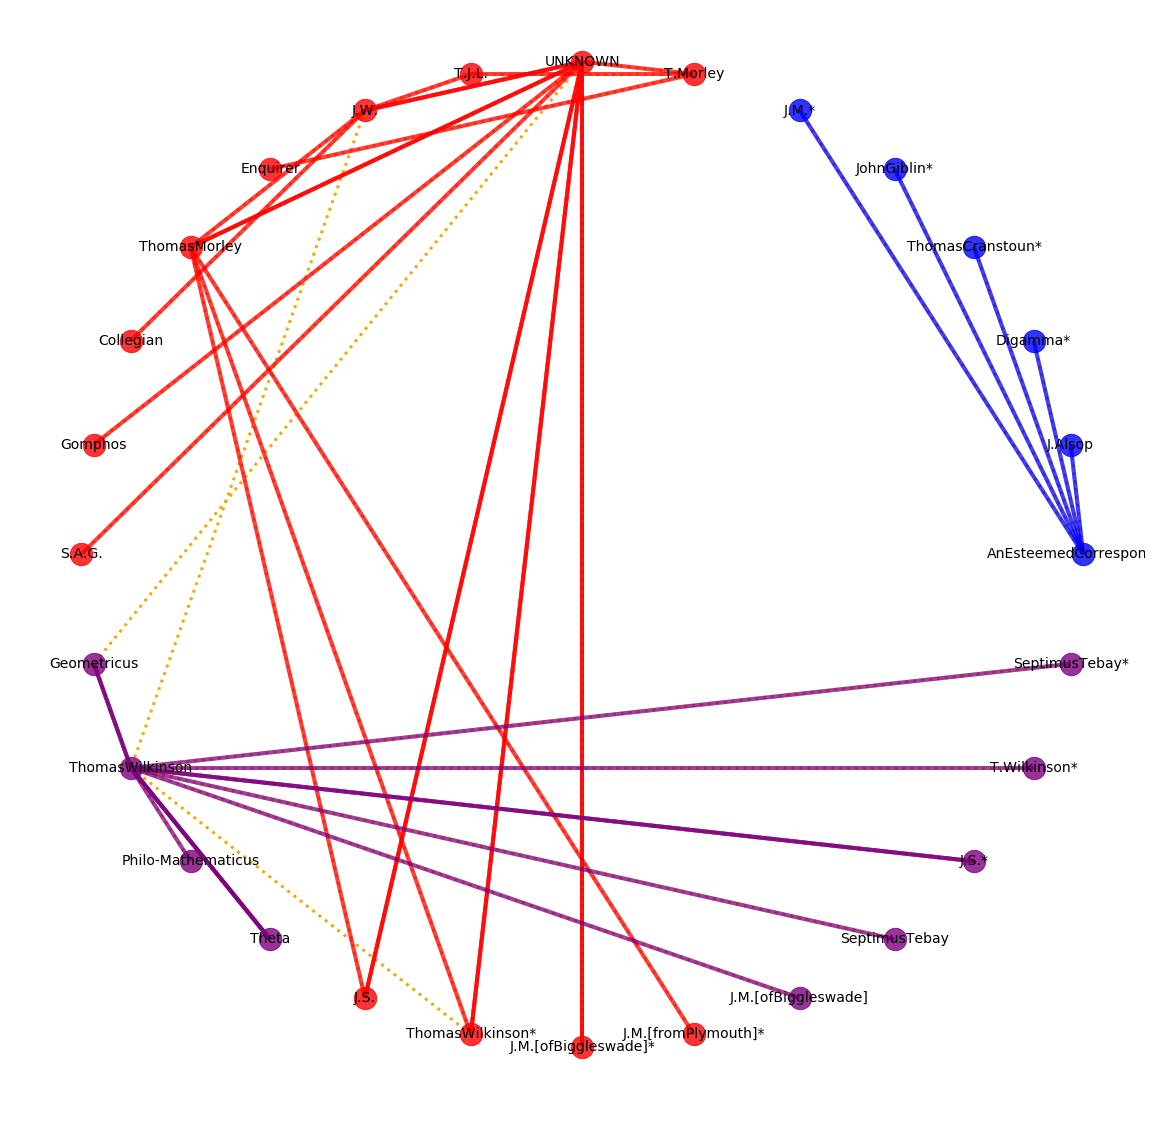

In [11]:
#Make a nice graph using nodeList and edgeList to color!!
D = nx.Graph()
D.add_edges_from(fixedSolver) #add ALL the edges from the initial list

#width, length
plt.figure(figsize=(20,20))
plt.axis('off')

# generate the layout and place nodes and edges
layout = nx.circular_layout(D, scale=3)

# plot nodes, labels, and edges with options
nx.draw_networkx_nodes(D,pos=layout,
                       nodelist=nodeList[0],
                       node_color='red',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_nodes(D,pos=layout,
                       nodelist=nodeList[1],
                       node_color='purple',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_nodes(D,pos=layout,
                       nodelist=nodeList[2],
                       node_color='blue',
                       node_size=500,
                   alpha=0.8)

#add all as dotted to begin with, that way those that were removed will show up as dotted
nx.draw_networkx_edges(D, pos=layout, width=3, style='dotted',
                       edge_color='orange')
nx.draw_networkx_edges(D,pos=layout,
                       edgelist=edgeList[0],
                       width=4,alpha=0.5,edge_color='red')
nx.draw_networkx_edges(D,pos=layout,
                       edgelist=edgeList[1],
                       width=4,alpha=0.5,edge_color='purple')
nx.draw_networkx_edges(D,pos=layout,
                       edgelist=edgeList[2],
                       width=4,alpha=0.5,edge_color='blue')
nx.draw_networkx_labels(D, pos=layout, font_size=14)

#plt.show()
plt.savefig("week7betweenness2.png", format="PNG")